In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

file_path = r"./masterset.xlsx"
print("Loading dataset:", file_path)
df = pd.read_excel(file_path)
print("Rows, Columns:", df.shape)

if 'ndvi' not in df.columns and 'nvdi' in df.columns:
    df = df.rename(columns={'nvdi': 'ndvi'})
    print("Renamed nvdi → ndvi")

if 'United States' in df.get('state', pd.Series([])).astype(str).unique():
    df = df[df['state'] != 'United States']

df = df.copy()
if 'loss_rate' not in df.columns:
    df['loss_rate'] = df['lost_colonies'] / df['max_colonies'].replace(0, np.nan)

for col in ['tavg','pcp','ndvi']:
    mean_col = f'{col}_state_mean'
    if mean_col not in df.columns and col in df.columns:
        df[mean_col] = df.groupby('state')[col].transform('mean')
    anom_col = f'{col}_anom'
    if anom_col not in df.columns and col in df.columns:
        df[anom_col] = df[col] - df[mean_col]

if 'bio_stress' not in df.columns:
    df['bio_stress'] = (
        df['varroa_mites'] + df['other_pests_and_parasites'] +
        df['diseases'] + df['pesticides']
    )
if 'turnover' not in df.columns:
    df['turnover'] = df['added_colonies'] + df['renovated_colonies']

sort_cols = ['state', 'year'] + (['quarter'] if 'quarter' in df.columns else [])
df = df.sort_values(sort_cols).reset_index(drop=True)

for col in ['ndvi','ndvi_anom','tavg_anom','pcp_anom','tavg','pcp']:
    if col in df.columns:
        df[f'{col}_lag1'] = df.groupby('state')[col].shift(1)

if 'ndvi' in df.columns:
    df['ndvi_change'] = df['ndvi'] - df['ndvi_lag1']
if 'ndvi_anom' in df.columns:
    df['ndvi_anom_change'] = df['ndvi_anom'] - df['ndvi_anom_lag1']

interactions = {}
if {'tavg_anom','ndvi_anom'}.issubset(df.columns):
    interactions['temp_veg_interaction'] = df['tavg_anom'] * df['ndvi_anom']
if {'pcp_anom','ndvi_anom'}.issubset(df.columns):
    interactions['rain_veg_interaction'] = df['pcp_anom'] * df['ndvi_anom']
if {'tavg_anom','pesticides'}.issubset(df.columns):
    interactions['temp_pest_interaction'] = df['tavg_anom'] * df['pesticides']
if {'pcp_anom','pesticides'}.issubset(df.columns):
    interactions['rain_pest_interaction'] = df['pcp_anom'] * df['pesticides']
if {'bio_stress','ndvi_anom'}.issubset(df.columns):
    interactions['bio_veg_interaction'] = df['bio_stress'] * df['ndvi_anom']

for k,v in interactions.items():
    df[k] = v

TARGET = 'percent_lost' if 'percent_lost' in df.columns else 'loss_rate'
cat_features = ['state'] + (['quarter'] if 'quarter' in df.columns else [])
veg_features = [c for c in ['ndvi','ndvi_anom','ndvi_lag1','ndvi_anom_lag1','ndvi_change','ndvi_anom_change'] if c in df.columns]
climate_features = [c for c in ['tavg','pcp','tavg_anom','pcp_anom','tavg_lag1','pcp_lag1','tavg_anom_lag1','pcp_anom_lag1'] if c in df.columns]
stress_features = [c for c in ['varroa_mites','other_pests_and_parasites','diseases','pesticides','bio_stress','turnover','added_colonies','renovated_colonies'] if c in df.columns]
inter_feature_names = list(interactions.keys())
num_features = veg_features + climate_features + stress_features + inter_feature_names

keep_cols = cat_features + num_features + [TARGET, 'year']
use = df[keep_cols].replace([np.inf,-np.inf], np.nan).dropna()
train = use[use['year'] < 2022].drop(columns=['year'])
test  = use[use['year'] == 2022].drop(columns=['year'])
X_train, y_train = train.drop(columns=[TARGET]), train[TARGET].values
X_test,  y_test  = test.drop(columns=[TARGET]),  test[TARGET].values

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

def make_ohe(sparse):
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=sparse)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=sparse)

ohe_dense = make_ohe(False)
prep_linear = ColumnTransformer([
    ('cat', ohe_dense, cat_features),
    ('num', StandardScaler(), num_features)
])

ohe_sparse = make_ohe(True)
prep_trees = ColumnTransformer([
    ('cat', ohe_sparse, cat_features),
    ('num', 'passthrough', num_features)
])

ridge = Pipeline([
    ('prep', prep_linear),
    ('model', Ridge(alpha=1.0, random_state=42))
])

rf = Pipeline([
    ('prep', prep_trees),
    ('model', RandomForestRegressor(
        n_estimators=600,
        min_samples_split=4,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ))
])

if HAS_XGB:
    xgb_pipe = Pipeline([
        ('prep', prep_trees),
        ('model', xgb.XGBRegressor(
            n_estimators=900,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            objective='reg:squarederror'
        ))
    ])
else:
    xgb_pipe = Pipeline([
        ('prep', prep_trees),
        ('model', GradientBoostingRegressor(
            n_estimators=900,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ])

mlp = Pipeline([
    ('prep', prep_linear),
    ('model', MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=700,
        random_state=42
    ))
])

models = [
    (ridge, 'Ridge (Bee Loss)'),
    (rf,    'Random Forest (Bee Loss)'),
    (xgb_pipe, 'XGB/GB (Bee Loss)'),
    (mlp,   'MLP (Bee Loss)')
]

def fit_eval(pipe, name):
    pipe.fit(X_train, y_train)
    p = pipe.predict(X_test)
    return {
        'Model': name,
        'R2_2022': r2_score(y_test, p),
        'MAE_2022': mean_absolute_error(y_test, p),
        'pipe': pipe,
        'pred_test': p
    }

results = []
trained = []
for mdl, name in models:
    res = fit_eval(mdl, name)
    trained.append(res)
    results.append({'Model': res['Model'], 'R2_2022': res['R2_2022'], 'MAE_2022': res['MAE_2022']})

results_df = pd.DataFrame(results).sort_values('R2_2022', ascending=False)
print("\nTest Year 2022")
print(results_df)

def extract_top_features(pipe, top_k=25):
    names = pipe.named_steps['prep'].get_feature_names_out()
    model = pipe.named_steps['model']
    if hasattr(model, 'coef_'):
        vals = model.coef_.ravel()
        out = pd.DataFrame({'feature': names, 'value': vals})
        out['abs'] = out['value'].abs()
        return out.sort_values('abs', ascending=False).head(top_k)
    if hasattr(model, 'feature_importances_'):
        vals = model.feature_importances_
        out = pd.DataFrame({'feature': names, 'value': vals})
        return out.sort_values('value', ascending=False).head(top_k)
    return pd.DataFrame()


Loading dataset: ./masterset.xlsx
Rows, Columns: (1364, 20)
Renamed nvdi → ndvi
Training samples: 1144
Test samples: 176

Test Year 2022
                      Model   R2_2022  MAE_2022
1  Random Forest (Bee Loss)  0.209236  4.625344
0          Ridge (Bee Loss)  0.145824  4.848588
2         XGB/GB (Bee Loss)  0.136607  4.918382
3            MLP (Bee Loss)  0.049367  5.418136



Feature Importance by Category (%)
Category
Vegetation    38.2
Climate       29.4
Biological    19.2
Management     7.5
Other          5.7
Name: importance, dtype: float64


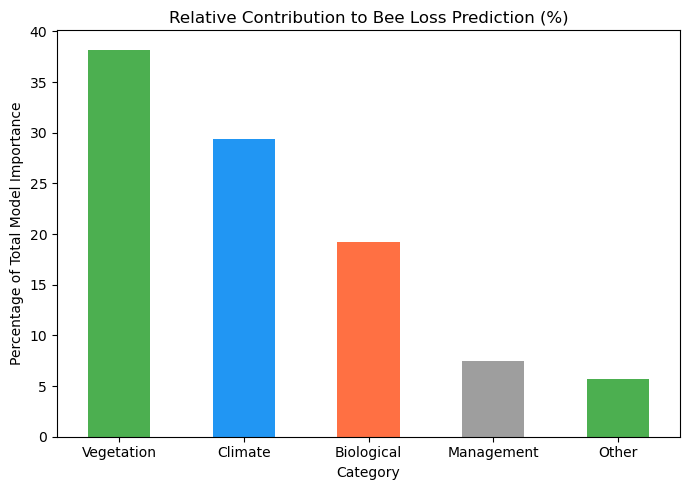

In [25]:
import pandas as pd

# Extract full importance list from the trained Random Forest
best_rf = [r for r in trained if "Random Forest" in r["Model"]][0]["pipe"]
rf_all_importances = extract_top_features(best_rf, top_k=9999)  # get all
rf_all_importances = rf_all_importances.rename(columns={'value':'importance'})

# Define category keywords
categories = {
    'Vegetation': ['ndvi', 'veg'],
    'Climate': ['tavg', 'pcp', 'rain', 'temp'],
    'Biological': ['varroa', 'pest', 'disease', 'bio'],
    'Management': ['turnover', 'renovated', 'added']
}

def categorize_feature(name):
    for cat, keys in categories.items():
        if any(k in name for k in keys):
            return cat
    return 'Other'

rf_all_importances['Category'] = rf_all_importances['feature'].apply(categorize_feature)
summary = rf_all_importances.groupby('Category')['importance'].sum().sort_values(ascending=False)
summary = (summary / summary.sum() * 100).round(1)  # convert to %
print("\nFeature Importance by Category (%)")
print(summary)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
summary.plot(kind='bar', color=['#4CAF50','#2196F3','#FF7043','#9E9E9E'])
plt.title("Relative Contribution to Bee Loss Prediction (%)")
plt.ylabel("Percentage of Total Model Importance")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


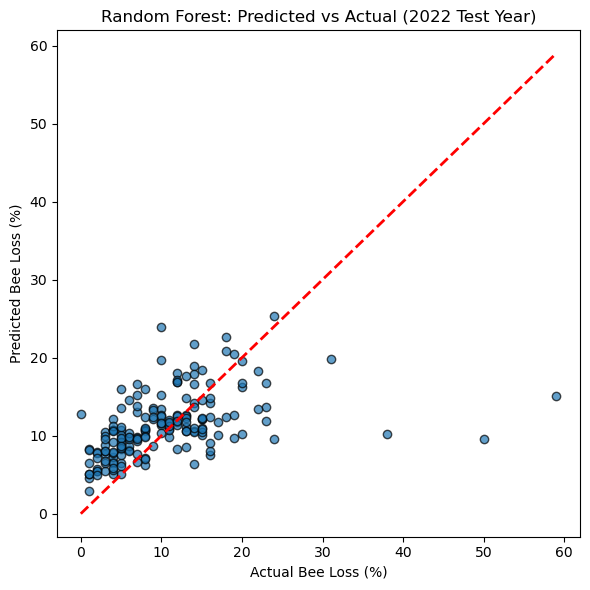

In [26]:
import matplotlib.pyplot as plt
import numpy as np

rf_result = [r for r in trained if "Random Forest" in r["Model"]][0]
y_true = y_test
y_pred = rf_result['pred_test']

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel("Actual Bee Loss (%)")
plt.ylabel("Predicted Bee Loss (%)")
plt.title("Random Forest: Predicted vs Actual (2022 Test Year)")
plt.tight_layout()
plt.show()

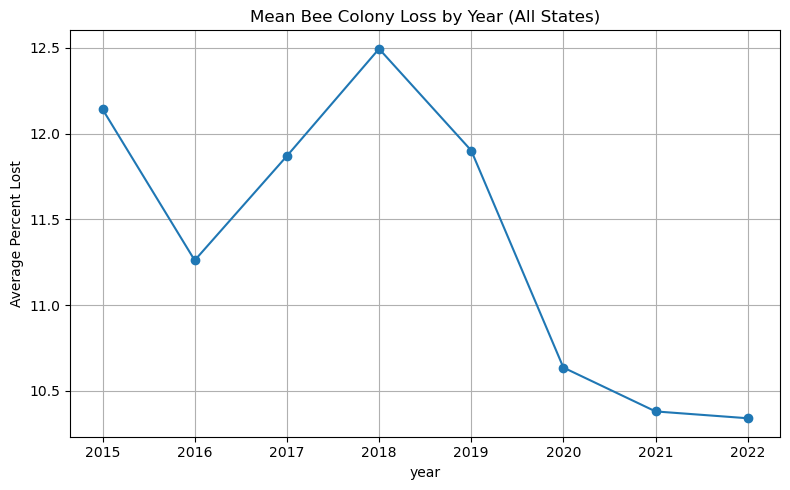

In [29]:
plt.figure(figsize=(8,5))
df.groupby('year')['percent_lost'].mean().plot(marker='o')
plt.ylabel("Average Percent Lost")
plt.title("Mean Bee Colony Loss by Year (All States)")
plt.grid(True)
plt.tight_layout()
plt.show()

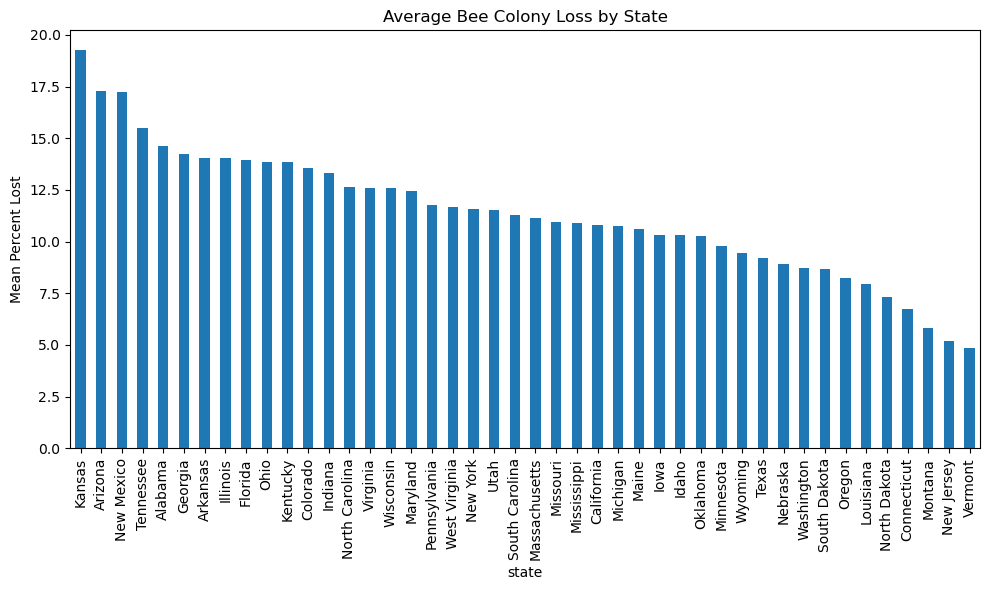

In [30]:
plt.figure(figsize=(10,6))
state_means = df.groupby('state')['percent_lost'].mean().sort_values(ascending=False)
state_means.plot(kind='bar')
plt.ylabel("Mean Percent Lost")
plt.title("Average Bee Colony Loss by State")
plt.tight_layout()
plt.show()